## Demo notebook for accessing Daymet data on Azure

The Daymet dataset contains daily minimum temperature, maximum temperature, precipitation, shortwave radiation, vapor pressure, snow water equivalent, and day length at 1km resolution for North America. The dataset covers the period from January 1, 1980 to December 31, 2019.

Daymet is available in both NetCDF and Zarr format on Azure; this notebook demonstrates access to the NetCDF data.

Daymet data are stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on Daymet data also be situated in West Europe.  You don't want to download terabytes of data to your laptop!  If you are using Daymet data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

In [1]:
# Standard or standard-ish imports
import os
import tempfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

# Less standard, but still pip- or conda-installable
import netCDF4 as nc 

from azure.storage.blob import ContainerClient
from netCDF4 import Dataset

container_name = 'daymet'
daymet_azure_storage_url = 'https://daymeteuwest.blob.core.windows.net/'

daymet_container_client = ContainerClient(account_url=daymet_azure_storage_url, 
                                         container_name=container_name,
                                         credential=None)

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(),'daymet')
os.makedirs(temp_dir,exist_ok=True)

### Support functions

In [2]:
def download_url(url, destination_filename=None, progress_updater=None, force_download=False):
    """
    Download a URL to a temporary file
    """
    
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('.', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        print('Bypassing download of already-downloaded file {}'.format(os.path.basename(url)))
        return destination_filename
    print('Downloading file {}'.format(os.path.basename(url)),end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)  
    assert(os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    print('...done, {} bytes.'.format(nBytes))
    return destination_filename

### List the available Daymet files
The Daymet dataset is available for anonymous public download on Azure.  The following code shows how to list all data files that are currently available, trimmed to a specific region (hawaii, na, puertorico) and year for brevity.

In [3]:
# Hawaii sounds nice...
state_of_interest = 'hawaii'
year_of_interest = '2019'

# List the blobs in the container
generator = daymet_container_client.list_blobs()
for blob in generator:
    if state_of_interest in blob.name and year_of_interest in blob.name:
        print('Blob name: ' + blob.name)

Blob name: daymet_v3_dayl_2019_hawaii.nc4
Blob name: daymet_v3_prcp_2019_hawaii.nc4
Blob name: daymet_v3_srad_2019_hawaii.nc4
Blob name: daymet_v3_swe_2019_hawaii.nc4
Blob name: daymet_v3_tmax_2019_hawaii.nc4
Blob name: daymet_v3_tmin_2019_hawaii.nc4
Blob name: daymet_v3_vp_2019_hawaii.nc4


### Download a specific file from Azure blob storage
This code shows how to download a specific file from Azure blob storage into the current directory.  It uses the example file daymet_v3_tmax_1980_hawaii.nc4, but you can change this as described below.  

The following types of data are available: minimum temperature (tmin), maximum temperature (tmax), precipitation (prcp), shortwave radiation (srad), vapor pressure (vp), snow water equivalent (swe), and day length (dayl).  


In [4]:
variable = 'tmax'
year = '2019'

# Choose your location.  The following are available: hawaii, na, puertorico.  The value 'na' stands for North America.
location = 'hawaii'

granule_name = 'daymet_v3_' + variable + '_' + year + '_' + location + '.nc4'
url = daymet_azure_storage_url + container_name + '/' + granule_name
print(url)
filename = download_url(url)

https://daymeteuwest.blob.core.windows.net/daymet/daymet_v3_tmax_2019_hawaii.nc4


### Explore the NetCDF metadata

In [5]:
daymet_ds = Dataset(filename, 'r') 
print('netCDF file format:' + ' ' + daymet_ds.file_format)

print('netCDF dimensions:')
print(daymet_ds.dimensions.keys())
print('\ntime dimension:')
print(daymet_ds.dimensions['time'])
print('x dimension:')
print(daymet_ds.dimensions['x'])
print('y dimension:')
print(daymet_ds.dimensions['y'])
print('netCDF variables:')
print(daymet_ds.variables.keys())
print('\n' + variable + ' variable and attributes:')
print(daymet_ds.variables[variable])

netCDF file format: NETCDF4_CLASSIC
netCDF dimensions:
dict_keys(['x', 'y', 'time', 'nv'])

time dimension:
<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 365
x dimension:
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 284
y dimension:
<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 584
netCDF variables:
dict_keys(['x', 'y', 'lat', 'lon', 'time', 'yearday', 'time_bnds', 'lambert_conformal_conic', 'tmax'])

tmax variable and attributes:
<class 'netCDF4._netCDF4.Variable'>
float32 tmax(time, y, x)
    _FillValue: -9999.0
    long_name: daily maximum temperature
    units: degrees C
    missing_value: -9999.0
    coordinates: lat lon
    grid_mapping: lambert_conformal_conic
    cell_methods: area: mean time: maximum
unlimited dimensions: time
current shape = (365, 584, 284)
filling off


### Plot temperature data
Let's calculate the mean value for the variable that we care about, and then visualize this on a map.  If you have kept the defaults above, this is the maximum temperature.  

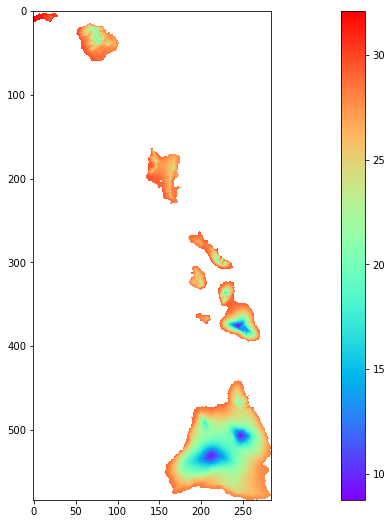

In [6]:
# Read the whole array
factor = daymet_ds.variables[variable][:]

# Calculate mean
factor_mean_comp = np.mean(factor, axis=0, keepdims=True)

# Reshape 
x_size = daymet_ds.dimensions['x'].size
y_size = daymet_ds.dimensions['y'].size
factor_mean_comp.shape = (y_size,x_size)

# Plot
%matplotlib inline
plt.rcParams['figure.figsize'] = (25,9)
plt.imshow(factor_mean_comp, cmap='rainbow')
plt.colorbar()

### Time conversion
Convert the time axis to a more human-readable format... mostly an excuse to demonstrate tinkering with NetCDF variables.

In [7]:
time = daymet_ds.variables['time'][:] 
time_unit = daymet_ds.variables['time'].getncattr('units') 
time_cal = daymet_ds.variables['time'].getncattr('calendar') 
local_time = nc.num2date(time, units=time_unit, calendar=time_cal)

print('Original time value: {}, human-readable time: {}'.format(time[0], local_time[0]))

Original time value: 14245.5, human-readable time: 2019-01-01 12:00:00


### Cleanup

In [8]:
daymet_ds.close()
shutil.rmtree(temp_dir)